In [24]:
%reload_ext autoreload
%autoreload 2

In [25]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm_notebook

T = torch.from_numpy
TD = TensorDataset
DL = DataLoader

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [26]:
import sys
sys.path.append('/home/yangz2/projects/bishop1995_notes/modules_for_nn_training')
from learner import Learner
from callbacks import CallbackHandler
from utility_callbacks import LossCallback, MulticlassAccuracyCallback, BinaryAccuracyCallback

from trainer import Trainer

In [27]:
RESULTS_DIR = '/home/yangz2/projects/gmvae_and_gmmvae/results'
GAME = 'smba'
MODEL = 'gmvae'

In [32]:
num_components_s = [2, 40]

In [33]:
for num_components in tqdm_notebook(num_components_s):
    
    with open(f'{RESULTS_DIR}/{GAME}_{MODEL}_generations/{GAME}_{MODEL}_{num_components}.json', 'r') as json_f:
        x = np.array(json.load(json_f))
        encoding_len = len(np.unique(x))
        x = np.eye(encoding_len)[x]
        x = x.reshape(-1, encoding_len * 16 * 16)
        
    y = np.repeat(np.arange(num_components), 500)
    
    seed = np.random.randint(1000)
    np.random.seed(seed)
    np.random.shuffle(x)
    np.random.seed(seed)
    np.random.shuffle(y)
    
    x_train, y_train = x[:300 * num_components], y[:300 * num_components]
    x_valid, y_valid = x[-200 * num_components:], y[-200 * num_components:]

    train_ds = TD(T(x_train), T(y_train))
    train_dl = DL(train_ds, batch_size=64, shuffle=True)

    valid_ds = TD(T(x_valid), T(y_valid))
    valid_dl = DL(valid_ds, batch_size=64, shuffle=False)
    
    class NN(nn.Module):
    
        def __init__(self, num_classes, input_dim):
            super().__init__()

            self.num_classes = num_classes

            self.main = nn.Sequential(

                nn.Linear(input_dim, 500),
                nn.BatchNorm1d(500),  # maintain health gradient flow
                nn.ReLU(),

                nn.Linear(500, 500),
                nn.BatchNorm1d(500),  # maintain health gradient flow
                nn.ReLU(),

                nn.Linear(500, self.num_classes),  # maintain health gradient flow
                nn.ReLU(),

            )

        def forward(self, xb):
            xb = self.main(xb)
            return xb.view(-1, self.num_classes)
    
    def get_model(input_dim, num_classes):
        nn = NN(num_classes, input_dim)
        return nn, optim.Adam(nn.parameters(), lr=10)
    
    model, opt = get_model(input_dim=x.shape[1], num_classes=num_components)
    loss = nn.CrossEntropyLoss()
    learn = Learner(train_dl, valid_dl, model, loss, opt)

    loss_cb = LossCallback()
    acc_cb = MulticlassAccuracyCallback()
    cb_handler = CallbackHandler(cbs=[loss_cb, acc_cb])

    trainer = Trainer(learn=learn, cb_handler=cb_handler)

#     trainer.find_lr(beta=0.98, final_value=100, num_itr=300)
    
    trainer.set_lr(5e-4)
    trainer.train(10)
    
    model.eval()
    output = model(valid_ds.tensors[0].float())
    ypred = output.detach().numpy().argmax(axis=1)
    conf_mat = confusion_matrix(y_valid, ypred)
    print(np.mean(y_valid == ypred))
    
    with open(f'{RESULTS_DIR}/{GAME}_{MODEL}_disentanglement_plots/confmat_{num_components}.json', 'w+') as json_f:
        json.dump(conf_mat.tolist(), json_f)

0.59


0.721



In [34]:
num_components_s = [2, 4, 6, 8, 10, 15, 20, 30, 40, 50]

In [35]:
confmats = []
for fname in sorted(
    [fn for fn in os.listdir(f'{RESULTS_DIR}/{GAME}_{MODEL}_disentanglement_plots') if fn.split('.')[-1] == 'json'], 
    key=lambda fn : int(fn.split('.')[0].split('_')[1])
):  
    with open(f'{RESULTS_DIR}/{GAME}_{MODEL}_disentanglement_plots/{fname}', 'r') as json_f:
        confmats.append(np.array(json.load(json_f)))

In [42]:
confmats[0]

array([[ 75, 129],
       [ 35, 161]])

In [37]:
len(num_components_s), len(confmats)

(10, 10)

In [59]:
accs_to_search = [70, 80, 90]
accs_s = [[] for k in accs_to_search]
for confmat in confmats:
    confmat = confmat / confmat.sum(axis=1).reshape(-1, 1)
    diag = confmat * np.eye(confmat.shape[0])
    for i, acc in enumerate(accs_to_search):
        accs_s[i].append(np.sum(diag[diag != 0] >= (acc / 100)))

In [50]:
np.array(accs_s).shape

(3, 10)

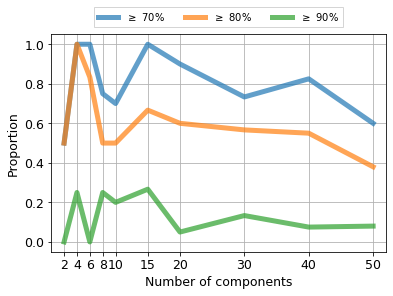

In [51]:
for i, (acc, accs) in enumerate(zip(accs_to_search, accs_s)):
    plt.plot(num_components_s, np.array(accs) / np.array(num_components_s), linewidth=5, alpha=0.7, label=f'$\geq$ {acc}%')
plt.xlabel('Number of components', fontsize=12.5); plt.ylabel('Proportion', fontsize=12.5)
plt.xticks(num_components_s, fontsize=12.5); plt.yticks(fontsize=12.5)
plt.xlim(0, 52)
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=False, shadow=False)
plt.savefig(f'{RESULTS_DIR}/{GAME}_{MODEL}_disentanglement_plots/{GAME}_{MODEL}_disentanglement.png', dpi=100)

In [84]:
print(np.min(np.array(accs_s[0]) / np.array(num_components_s)))
print(np.mean(np.array(accs_s[0]) / np.array(num_components_s)))
print(np.max(np.array(accs_s[0]) / np.array(num_components_s)))

print(np.min(np.array(accs_s[1]) / np.array(num_components_s)))
print(np.mean(np.array(accs_s[1]) / np.array(num_components_s)))
print(np.max(np.array(accs_s[1]) / np.array(num_components_s)))

print(np.min(np.array(accs_s[2]) / np.array(num_components_s)))
print(np.mean(np.array(accs_s[2]) / np.array(num_components_s)))
print(np.max(np.array(accs_s[2]) / np.array(num_components_s)))

0.5
0.8008333333333333
1.0
0.38
0.6096666666666666
1.0
0.0
0.1305
0.26666666666666666
